# SpaceWars

> The location of reporting the Great War in France, Austria and Finland – investigating the places dominating news reporting during the Great War between 1914 and 1918

- https://platform.newseye.eu/

### MultiBERT

In [1]:
!python3 --version

Python 3.6.9


In [2]:
from os.path import join
from os import listdir

listdir(join('multi_cased_L-12_H-768_A-12'))

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta',
 'vocab.txt']

In [22]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('logs')
writer

In [4]:
from sklearn.datasets import fetch_20newsgroups

news = fetch_20newsgroups()
len(news.data)

11314

In [39]:
import math

max_length = math.floor(np.mean([len(art.split()) for art in news.data]))

In [40]:
from transformers import BertTokenizer, BertModel

MODEL = 'bert-base-multilingual-cased'

tokenizer = BertTokenizer.from_pretrained(MODEL)

encoded_input = tokenizer(news.data[:10], padding=True, truncation=True, max_length=max_length, return_tensors='pt')

encoded_input['input_ids']

tensor([[  101, 12222,   131,  ...,     0,     0,     0],
        [  101, 12222,   131,  ...,     0,     0,     0],
        [  101, 12222,   131,  ..., 10124,   113,   102],
        ...,
        [  101, 12222,   131,  ...,   122,   119,   102],
        [  101, 12222,   131,  ...,     0,     0,     0],
        [  101, 12222,   131,  ..., 24909, 11614,   102]])

In [41]:
encoded_input['input_ids'].shape

torch.Size([10, 287])

In [42]:
import torch

model = BertModel.from_pretrained(MODEL, output_hidden_states=False, output_attentions=True)
# writer.add_graph(model)
model.eval()

with torch.no_grad():
    output = model(**encoded_input)

output.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'attentions'])

### Visualization

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.figure(figsize=(20, 10))

layer_id = 5
sent_id = 0
head_id = 1

tokens = tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][sent_id])
attention = pd.DataFrame(output.attentions[layer_id][sent_id][head_id].detach().numpy(), index=tokens, columns=tokens)

ax = sns.heatmap(attention, annot=True)

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fda158a5d08> (for post_execute):


KeyboardInterrupt: 

In [43]:
from sklearn.decomposition import PCA

In [44]:
pca = PCA(n_components=2)

dims = output[0].shape

vectors = output[0].detach().numpy().reshape(dims[0]*dims[1], 768)

output_2d = pca.fit_transform(vectors)

In [45]:
tokens = ' '.join([' '.join(tokenizer.tokenize(tokenizer.batch_decode(encoded_input['input_ids'])[i])) for i in range(10)]).split()
' '.join(tokens)

'[CLS] From : ler ##x ##st @ wa ##m . um ##d . edu ( where \' s my thing ) Sub ##ject : W ##HA ##T car is this ! ? N ##nt ##p - Post ##ing - Host : ra ##c ##3 . wa ##m . um ##d . edu Organization : University of Maryland , College Park Lines : 15 I was won ##dering if anyone out there could en ##light ##en me on this car I saw the other day . It was a 2 - door sports car , looked to be from the late 60 ##s / early 70 ##s . It was called a Brick ##lin . The doors were really small . In addition , the front bu ##mper was separate from the rest of the body . This is all I know . If anyone can tell ##me a model name , engine sp ##ec ##s , years of production , where this car is made , history , or whatever info you have on this funk ##y looking car , pl ##eas ##e e - mail . Thank ##s , - IL - - - - brought to you by your neighborhood Le ##r ##x ##st - - - - [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [46]:
import tensorflow as tf
import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

writer.add_embedding(vectors, metadata=tokens)
writer.close()

In [47]:
import pandas as pd

output_2d = pd.DataFrame(output_2d, columns=['x', 'y'])
output_2d.shape

(2870, 2)

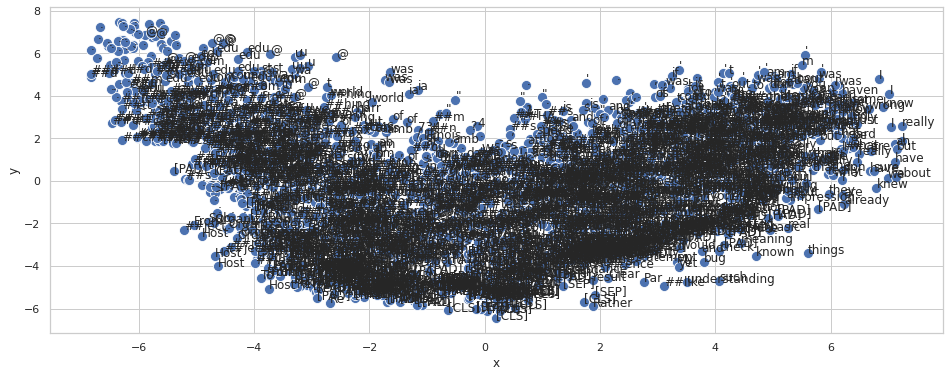

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))

sns.set(style='whitegrid')
 
scatter = sns.scatterplot(data=output_2d, x='x', y='y', s=100)

for i in range(output_2d.shape[0]): scatter.annotate(tokens[i], (output_2d.x[i], output_2d.y[i]))

In [49]:
%load_ext tensorboard
%tensorboard --logdir /home/vagrant/project/logs/ --host 0.0.0.0 --port 6006

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 2211), started 0:23:12 ago. (Use '!kill 2211' to kill it.)

In [29]:
!ps -fA | grep tensorboard

vagrant   2176  2114  2 23:11 ?        00:00:07 [tensorboard] <defunct>
vagrant   2208  2114 10 23:16 pts/1    00:00:00 /bin/bash -c ps -fA | grep tensorboard
vagrant   2210  2208  0 23:16 pts/1    00:00:00 grep tensorboard


In [21]:
!kill 2176

### Sources
- https://stackoverflow.com/questions/61250311/error-importing-bert-module-tensorflow-api-v2-train-has-no-attribute-optimi#
- https://medium.com/@armandj.olivares/using-bert-for-classifying-documents-with-long-texts-5c3e7b04573d
- https://huggingface.co/transformers/main_classes/output.html
- https://medium.com/analytics-vidhya/text-classification-with-bert-using-transformers-for-long-text-inputs-f54833994dfd
- https://towardsdatascience.com/transformers-141e32e69591
- https://pytorch.org/tutorials/intermediate/tensorboard_tutorial.html#adding-a-projector-to-tensorboard

#### Multilingual models
- https://huggingface.co/bert-base-multilingual-cased
- https://github.com/google-research/bert/blob/master/multilingual.md
- https://huggingface.co/transformers/multilingual.html

### References
- https://arxiv.org/abs/1810.04805
- https://www.aclweb.org/anthology/2020.tacl-1.54.pdf
- http://www.dhgarrette.com/papers/pires_multilingual_bert_acl2019.pdf